**Set up notebook:**

In [1]:
import sys
sys.path.append('../')
sys.path.append('../library/')
sys.path.append('../library/LogPai/')
sys.path.append('../Dataset/')

In [2]:
#@title Import required libraries for this notebook
from library.malib import *
import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

In [3]:
data_folder = '~/MA/Dataset/'

In [4]:
#OVERRIDE
def get_log_feature(logs: pd.DataFrame, log_msg_column, string_query):
  filtered_logs = logs[logs[log_msg_column].str.contains(string_query).fillna(False)]
  index = filtered_logs.index.name
  filtered_logs = filtered_logs.reset_index().drop_duplicates().set_index(index)

  log_feature = filtered_logs[log_msg_column].str.findall(string_query + ' *(\d*)').apply(lambda row: int(row[0]))

  return log_feature

In [5]:
#Custom function to generate time-based weighted averages when aggregating
#time-series data after resampling
def func(df, minutes=10):
    if df.size == 0: return
    timestep = 60 * minutes
    indexes = df.index - (df.index[-1] - pd.Timedelta(seconds=timestep))
    seconds = indexes.seconds
    weight = [seconds[n]/timestep if n == 0 else (seconds[n] - seconds[n - 1])/timestep
        for n, k in enumerate(seconds)]
    return np.sum(weight*df.values)

In [6]:
def time_based_merge(T_data, log_data, columns):

  #Time-Based Weighted-Averaged Log Data
  tbwa_log_data = log_data.resample('10T').apply(func)
  log_data = log_data.resample('10T').last().fillna(method='ffill')

  for column in columns:
    #Get transitional values (!= 0, 1, 2, 3) generated as a result of func
    transitional_values = tbwa_log_data[column][~tbwa_log_data[column].isin(log_data[column].values)]
    log_data[column].loc[transitional_values.index] = transitional_values

    #Just in case the last value was not an integer, this will mess up the ffill algorithm
    log_data[column].iloc[-1] = np.ceil(log_data[column].iloc[-1])

    #Merge signals dataset with log data, fill gaps on the front based on the value from the first occuring non-null values
    T_data = pd.merge_asof(T_data, log_data[column], left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(1.0)
  
  return T_data


**Data preprocessing...**

**Load dataset:**

In [7]:
#Read WTG data
signals_train = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'
all_data = load_data(data_folder=data_folder, file_name_1=signals_train, file_name_2=signals_test, time_index_column='Timestamp', delimeter=';')

#Read log data
logs_2016 = 'wind-farm-1-logs-2016.csv'
logs_2017 = 'wind-farm-1-logs-2017.csv'
log_data = load_data(data_folder=data_folder, file_name_1=logs_2016, file_name_2=logs_2017, time_index_column='TimeDetected', delimeter=';')
log_data = log_data.loc[log_data.index.notnull()]

#Reference/Validation turbine: Filter T_01 data out
T01_data = all_data[all_data.Turbine_ID == 'T01']
log_data_T01 = log_data[log_data['UnitTitle'] == 'T01']

#Remove duplicates in Timestamp index: Usually occurs at daylight saving
T01_data = T01_data[~T01_data.index.duplicated(keep='first')]

**Extract log feature manually:**

In [8]:
#Extract log feature
log_filt_T01 = log_data_T01[(log_data_T01.Remark == 'Run') | 
                            (log_data_T01.Remark.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) | 
                            (log_data_T01.Remark.str.contains('new SERVICE state', case=False, na=False))
                            ].Remark
log_filt_T01.loc[(log_filt_T01 == 'Run') | 
                 (log_filt_T01.str.contains('new SERVICE state: 0', case=False, na=False))
                 ] = 1
log_filt_T01.loc[(log_filt_T01.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) | 
                 (log_filt_T01.str.contains('new SERVICE state: 1', case=False, na=False))
                 ] = 0

max_power = 2000
log_curt_T01 = get_log_feature(log_data_T01, 'Remark', 'External power ref.:')
log_curt_T01 = log_curt_T01.replace(9999, float('inf'))
log_curt_T01 = log_curt_T01 / max_power

<ipython-input-8-ac229ece8816>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (log_data_T01.Remark.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) |
<ipython-input-8-ac229ece8816>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_filt_T01.loc[(log_filt_T01 == 'Run') |
<ipython-input-8-ac229ece8816>:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  log_filt_T01.loc[(log_filt_T01.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) |
<ipython-input-8-ac229ece8816>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

In [9]:
pd.DataFrame(log_data_T01[
                            (log_data_T01.Remark.str.contains('External power ref.:', case=False, na=False))
                            ]).to_csv('clogs.csv')

**Append log feature to signals:**

In [10]:
#Append log feature to signals
T01_data_logs = pd.merge_asof(T01_data, log_filt_T01, left_index = True, right_index = True, tolerance=pd.Timedelta('10T')).fillna(method='ffill')
T01_data_logs['Remark'] = T01_data_logs['Remark'].fillna(1 - T01_data_logs[T01_data_logs['Remark'].notnull()].iloc[0]['Remark'])

log_curt_T01.name = 'curt_factor'
#T01_data_logs = pd.merge_asof(T01_data_logs, log_curt_T01, left_index = True, right_index = True, tolerance=pd.Timedelta('10T')).fillna(method='ffill').fillna(1)
T01_data_logs = time_based_merge(T01_data_logs, pd.DataFrame(log_curt_T01), ['curt_factor'])

**EDA...**

In [11]:
#Selected features
#features_w_logs = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg', 'Int_Vent', 'Ext_Vent']
target_features = ['Grd_Prod_Pwr_Avg']
features_wout_logs = ['Amb_Temp_Avg', 'Amb_WindSpeed_Avg'] + target_features
features_w_logs = features_wout_logs + ['Remark']
target_feature = 'Grd_Prod_Pwr_Avg'


#Train/Test Periods
train_start_T01 = '2016-09-01'
train_end_T01 = '2017-08-30'
test_start_T01 = '2017-09-01'
test_end_T01 = '2017-12-31'

T01_data_logs.loc[train_start_T01 : train_end_T01, 'dataset'] = 'Train'
T01_data_logs.loc[test_start_T01 : test_end_T01, 'dataset'] = 'Test'

Distribution of Features (T01)

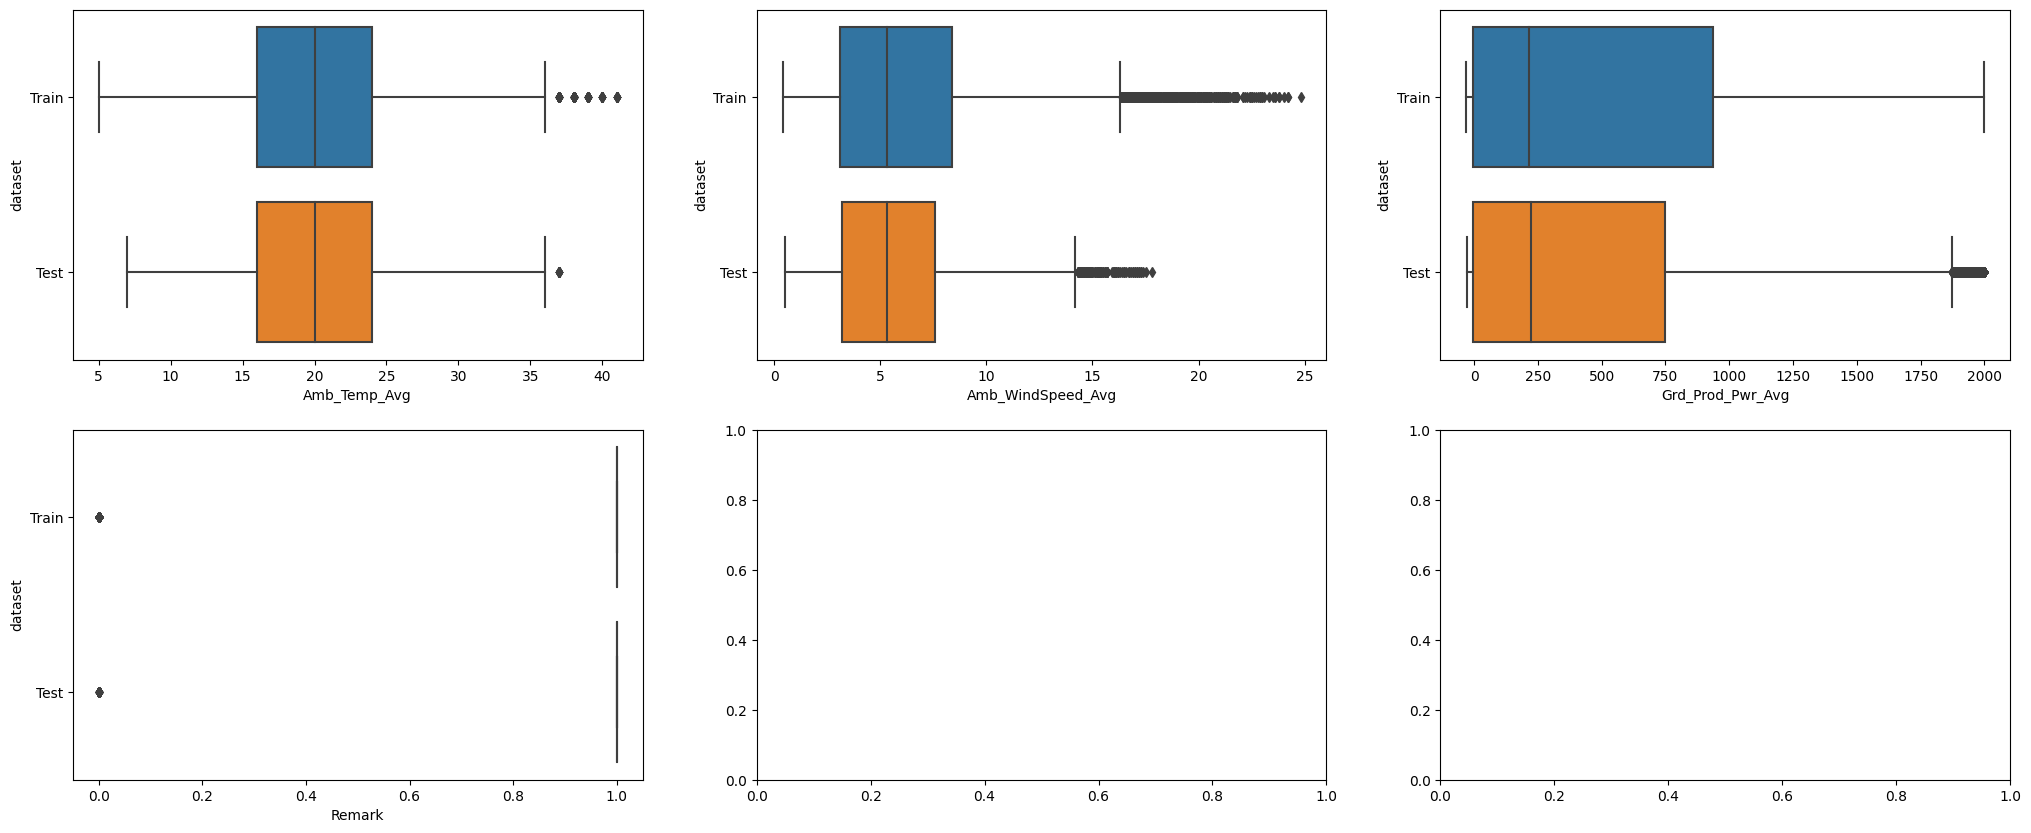

In [12]:
%matplotlib inline
fig, axes = plt.subplots((len(features_w_logs)//3) + 1, 3, figsize=(25,10))
for (i, feature) in zip(range(len(features_w_logs)), features_w_logs):
  sns.boxplot(data = T01_data_logs, x=feature, y='dataset', ax=axes[i//3][i%3])

**NBM for T01(Healthy reference turbine)**

In [13]:
# df = T01_data_logs_scaled.copy()
# df['diff'] = np.where(T01_data_logs_scaled[target_feature] != T01_data_logs[target_feature], True, False)
# print(df[df['diff']][[target_feature, 'curt_factor', 'Remark']])
# T01_data_logs[df['diff']][[target_feature, 'curt_factor', 'Remark']]

**Deep Learning**

In [14]:
#Train with log features
T01_data_logs_scaled = T01_data_logs.copy()
T01_data_logs_scaled.loc[:, target_feature] = (T01_data_logs_scaled[target_feature] / T01_data_logs_scaled['curt_factor']).clip(upper=max_power)
dataset_1, X_train_1, Y_train_1, predictions_train_1, errors_train_1, X_test_1, Y_test_1, predictions_test_1, errors_test_1, model_1, scaler_input, scaler_target, rmse_train_1, rmse_test_1 = \
                        implement_pipeline_mlp(T01_data_logs_scaled[T01_data_logs_scaled.Remark == 1], train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_w_logs, epochs=100, normalize=True);

Training model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
512/512 - 4s - loss: 0.0384 - 4s/epoch - 8ms/step
Epoch 2/100
512/512 - 4s - loss: 0.0060 - 4s/epoch - 8ms/step
Epoch 3/100
512/512 - 3s - loss: 0.0044 - 3s/epoch - 7ms/step
Epoch 4/100
512/512 - 3s - loss: 0.0038 - 3s/epoch - 7ms/step
Epoch 5/100
512/512 - 3s - loss: 0.0033 - 3s/epoch - 7ms

In [15]:
#Train filtered data by log feature
dataset_1_f, X_train_1_f, Y_train_1_f, predictions_train_1_f, errors_train_1_f, X_test_1_f, Y_test_1_f, predictions_test_1_f, errors_test_1_f, model_1_f, scaler_input, scaler_target, rmse_train_1_f, rmse_test_1_f = \
                        implement_pipeline_mlp(T01_data_logs[T01_data_logs.Remark == 1], train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=100, normalize=True);

Training model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                30        
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
512/512 - 3s - loss: 0.0344 - 3s/epoch - 7ms/step
Epoch 2/100
512/512 - 3s - loss: 0.0048 - 3s/epoch - 6ms/step
Epoch 3/100
512/512 - 3s - loss: 0.0040 - 3s/epoch - 6ms/step
Epoch 4/100
512/512 - 3s - loss: 0.0034 - 3s/epoch - 6ms/step
Epoch 5/100
512/512 - 3s - loss: 0.0028 - 3s/epoch - 6

In [16]:
#Train with filtered data based on rotor speed
dataset_1_fr, X_train_1_fr, Y_train_1_fr, predictions_train_1_fr, errors_train_1_fr, X_test_1_fr, Y_test_1_fr, predictions_test_1_fr, errors_test_1_fr, model_1_fr, scaler_input, scaler_target, rmse_train_1_fr, rmse_test_1_fr = \
                        implement_pipeline_mlp(T01_data_logs[T01_data_logs.Rtr_RPM_Avg > 0], train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=100, normalize=True);

Training model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                30        
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
449/449 - 3s - loss: 0.0420 - 3s/epoch - 7ms/step
Epoch 2/100
449/449 - 3s - loss: 0.0051 - 3s/epoch - 6ms/step
Epoch 3/100
449/449 - 3s - loss: 0.0034 - 3s/epoch - 6ms/step
Epoch 4/100
449/449 - 3s - loss: 0.0027 - 3s/epoch - 6ms/step
Epoch 5/100
449/449 - 3s - loss: 0.0023 - 3s/epoch - 7

In [17]:
#Train without log features
dataset_1_x, X_train_1_x, Y_train_1_x, predictions_train_1_x, errors_train_1_x, X_test_1_x, Y_test_1_x, predictions_test_1_x, errors_test_1_x, model_1_x, scaler_input, scaler_target, rmse_train_1_x, rmse_test_1_x = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=100, normalize=True);

Training model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                30        
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
521/521 - 3s - loss: 0.0390 - 3s/epoch - 7ms/step
Epoch 2/100
521/521 - 3s - loss: 0.0106 - 3s/epoch - 6ms/step
Epoch 3/100
521/521 - 3s - loss: 0.0098 - 3s/epoch - 6ms/step
Epoch 4/100
521/521 - 3s - loss: 0.0093 - 3s/epoch - 6ms/step
Epoch 5/100
521/521 - 3s - loss: 0.0089 - 3s/epoch - 7

Text(0.5, 0, 'Average ambient wind speed (m/s)')

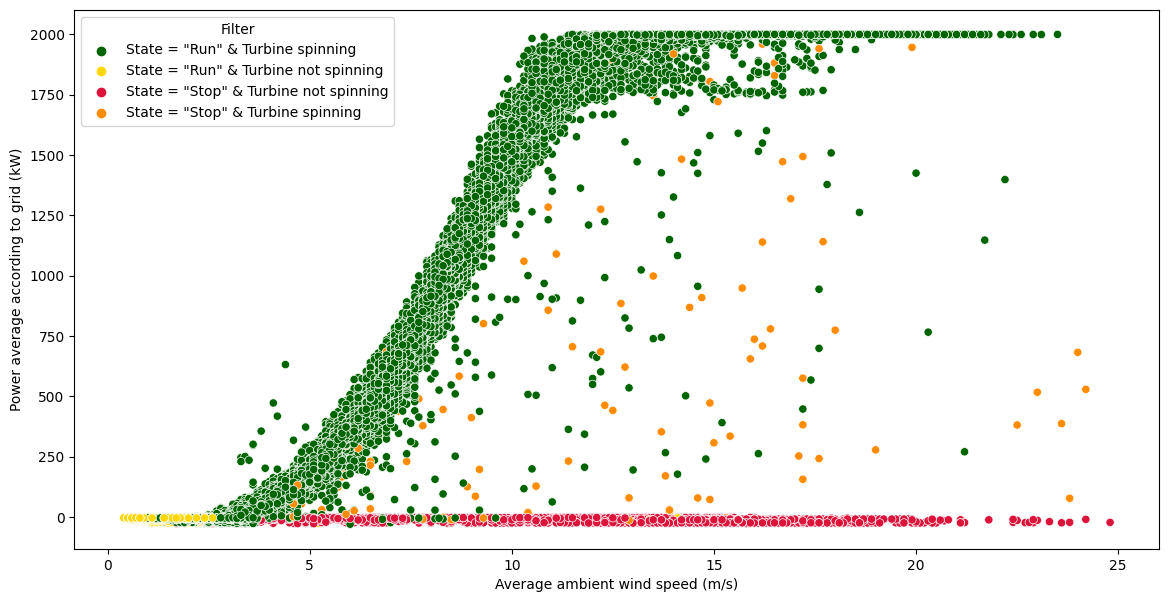

In [312]:
plt.figure(figsize=(14,7))
copy_1 = T01_data_logs.copy()
copy_1['Blades_Spinning'] = copy_1.Rtr_RPM_Avg > 0
# copy_1['Remark'][copy_1['Remark'] == 0] = 'Stop'
# copy_1['Remark'][copy_1['Remark'] == 1] = 'Run'
#copy_1 = copy_1.rename(columns={'Remark': 'Turbine\'s state of operation based on SCADA log feature'})

copy_1['Filter'] = ''

# copy_1.loc[(~copy_1['Blades_Spinning']), 'filter'] = 'Blades speed = 0'
# copy_1.loc[(copy_1['Blades_Spinning']), 'filter'] = 'Blades speed > 0'

# copy_1.loc[copy_1['Remark'] == 1, 'filter'] = 'State = "Run"'
# copy_1.loc[copy_1['Remark'] == 0, 'filter'] = 'State = "Stop"'


copy_1.loc[(copy_1['Remark'] == 1) & (copy_1['Blades_Spinning']), 'Filter'] = 'State = "Run" & Turbine spinning'
copy_1.loc[(copy_1['Remark'] == 0) & (~copy_1['Blades_Spinning']), 'Filter'] = 'State = "Stop" & Turbine not spinning'

copy_1.loc[(copy_1['Remark'] == 1) & (~copy_1['Blades_Spinning']), 'Filter'] = 'State = "Run" & Turbine not spinning'
copy_1.loc[(copy_1['Remark'] == 0) & (copy_1['Blades_Spinning']), 'Filter'] = 'State = "Stop" & Turbine spinning'

# copy_2 = T01_data_logs.copy()
# copy_2['Blades_Spinning'] = copy_2.Rtr_RPM_Avg > 0

x='Amb_WindSpeed_Avg'
y='Grd_Prod_Pwr_Avg'

sns.scatterplot(x=x, y=y, data=copy_1, hue='Filter', palette=['darkgreen', 'gold', 'crimson', 'darkorange'])
# sns.stripplot(x=x, y=y, data=copy_2[~copy_2['Blades_Spinning']].drop_duplicates([x, y]), color='blue', label='Blades speed = 0', alpha=0.5)
# sns.stripplot(x=x, y=y, data=copy_1[copy_1.Remark == 0].drop_duplicates([x, y]), color = 'orange', label='State = "Stop"', alpha=0.5)

plt.ylabel('Power average according to grid (kW)')
plt.xlabel('Average ambient wind speed (m/s)')

<AxesSubplot: xlabel='Amb_WindSpeed_Avg', ylabel='Grd_Prod_Pwr_Avg'>

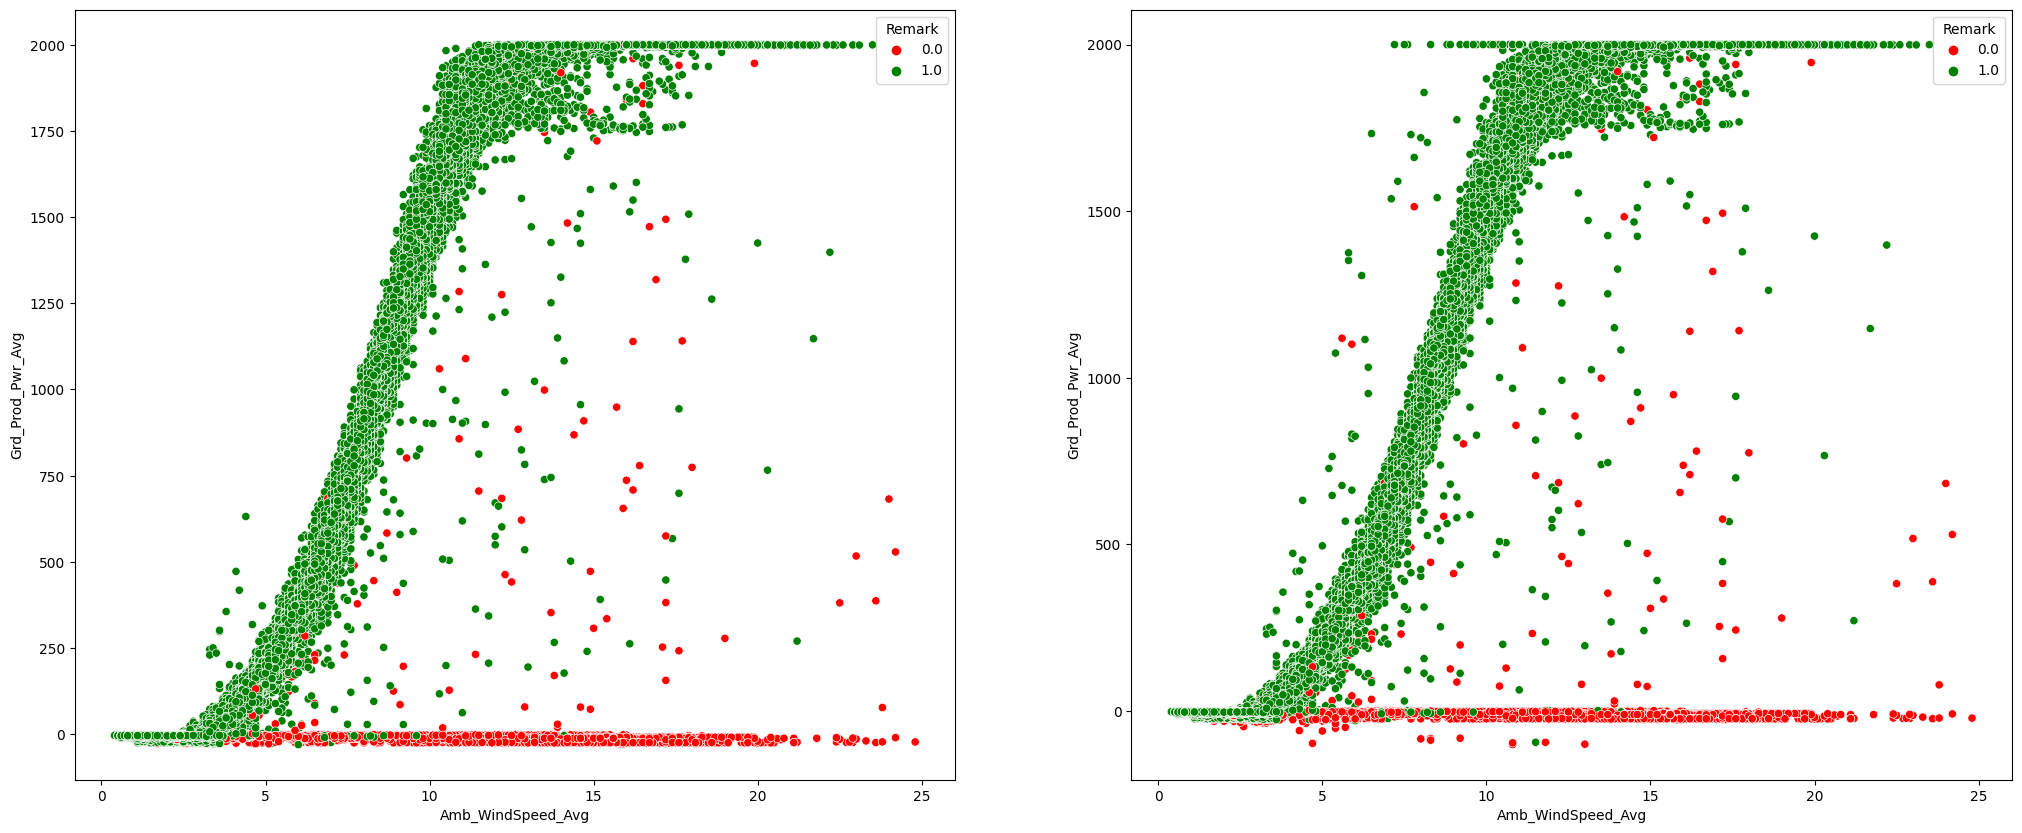

In [268]:
fig, axes = plt.subplots(1, 2, figsize=(25,10))
sns.scatterplot(x='Amb_WindSpeed_Avg', y='Grd_Prod_Pwr_Avg', data=T01_data_logs, hue='Remark', palette=['red', 'green'], ax=axes[0])
sns.scatterplot(x='Amb_WindSpeed_Avg', y='Grd_Prod_Pwr_Avg', data=T01_data_logs_scaled, hue='Remark', palette=['red', 'green'], ax=axes[1])

In [277]:
pd.concat([Y_test_1_x, predictions_test_1_x])

Grd_Prod_Pwr_Avg       dataset  Amb_WindSpeed_Avg
Timestamp                                                                   
2017-09-01 00:00:00+00:00        183.900000  Ground truth                NaN
2017-09-01 00:10:00+00:00        259.900000  Ground truth                NaN
2017-09-01 00:20:00+00:00        333.800000  Ground truth                NaN
2017-09-01 00:30:00+00:00        146.500000  Ground truth                NaN
2017-09-01 00:40:00+00:00        115.900000  Ground truth                NaN
...                                     ...           ...                ...
2017-12-31 23:10:00+00:00        318.969116    Prediction                6.3
2017-12-31 23:20:00+00:00        334.379700    Prediction                6.4
2017-12-31 23:30:00+00:00        168.935333    Prediction                5.3
2017-12-31 23:40:00+00:00        173.259338    Prediction                5.3
2017-12-31 23:50:00+00:00        188.205338    Prediction                5.4

[35064 rows x 3 columns]

In [308]:
predictions_test_1_x[predictions_test_1_x['Grd_Prod_Pwr_Avg'] >= 80].sort_values(
    ['Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg'], ascending=[True, False])

Grd_Prod_Pwr_Avg     dataset  Amb_WindSpeed_Avg
Timestamp                                                                 
2017-12-01 03:20:00+00:00         83.959129  Prediction                4.5
2017-12-01 03:30:00+00:00         83.959129  Prediction                4.5
2017-12-12 06:50:00+00:00         83.959129  Prediction                4.5
2017-12-12 07:40:00+00:00         83.959129  Prediction                4.5
2017-12-01 03:00:00+00:00         94.581100  Prediction                4.6
...                                     ...         ...                ...
2017-10-03 08:00:00+00:00       1764.081177  Prediction               17.3
2017-10-15 14:30:00+00:00       1745.289551  Prediction               17.3
2017-12-11 07:10:00+00:00       1807.284058  Prediction               17.4
2017-10-03 07:40:00+00:00       1751.143921  Prediction               17.5
2017-10-03 07:50:00+00:00       1731.738037  Prediction               17.8

[9852 rows x 3 columns]

In [306]:
predictions_test_1_f[predictions_test_1_f['Grd_Prod_Pwr_Avg'] >= 80].sort_values(
    ['Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg'], ascending=[True, False])

Grd_Prod_Pwr_Avg     dataset  Amb_WindSpeed_Avg
Timestamp                                                                 
2017-12-16 08:10:00+00:00         80.919121  Prediction                4.1
2017-12-01 03:10:00+00:00         98.301964  Prediction                4.2
2017-12-01 05:30:00+00:00         96.058800  Prediction                4.2
2017-12-03 08:50:00+00:00         96.058800  Prediction                4.2
2017-12-01 04:30:00+00:00         94.635971  Prediction                4.2
...                                     ...         ...                ...
2017-10-15 14:30:00+00:00       2048.901611  Prediction               17.3
2017-10-03 08:00:00+00:00       2028.737793  Prediction               17.3
2017-12-11 07:10:00+00:00       2027.274170  Prediction               17.4
2017-10-03 07:40:00+00:00       2026.945679  Prediction               17.5
2017-10-03 07:50:00+00:00       2024.258057  Prediction               17.8

[11083 rows x 3 columns]

In [307]:
predictions_test_1_fr[predictions_test_1_fr['Grd_Prod_Pwr_Avg'] >= 80].sort_values(
    ['Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg'], ascending=[True, False])

Grd_Prod_Pwr_Avg     dataset  Amb_WindSpeed_Avg
Timestamp                                                                 
2017-09-12 14:40:00+00:00         85.196281  Prediction                4.1
2017-09-12 13:10:00+00:00         84.995979  Prediction                4.1
2017-09-05 18:30:00+00:00         84.695572  Prediction                4.1
2017-09-21 14:50:00+00:00         84.495338  Prediction                4.1
2017-09-30 14:20:00+00:00         84.495338  Prediction                4.1
...                                     ...         ...                ...
2017-10-15 14:30:00+00:00       1984.925293  Prediction               17.3
2017-10-03 08:00:00+00:00       1984.132812  Prediction               17.3
2017-12-11 07:10:00+00:00       1974.653442  Prediction               17.4
2017-10-03 07:40:00+00:00       1982.123413  Prediction               17.5
2017-10-03 07:50:00+00:00       1979.109253  Prediction               17.8

[11316 rows x 3 columns]

Text(0.5, 0, 'Average ambient wind speed (m/s)')

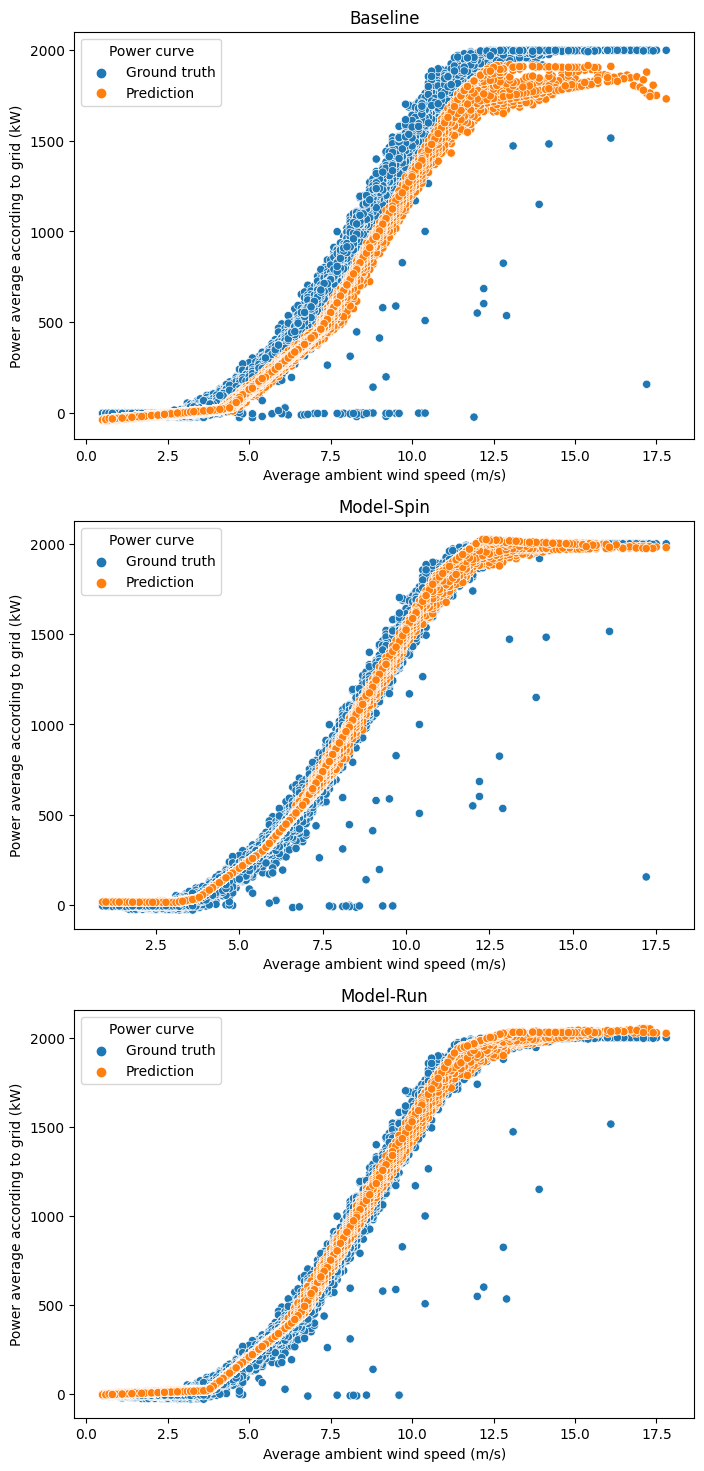

In [324]:
fig, axes = plt.subplots(3, 1, figsize=(8,18))
Y_test_1_x['Power curve'] = 'Ground truth'
Y_test_1_x['Amb_WindSpeed_Avg'] = dataset_1_x['Amb_WindSpeed_Avg']
predictions_test_1_x['Power curve'] = 'Prediction'
predictions_test_1_x['Amb_WindSpeed_Avg'] = dataset_1_x['Amb_WindSpeed_Avg']

Y_test_1_f['Power curve'] = 'Ground truth'
Y_test_1_f['Amb_WindSpeed_Avg'] = dataset_1_x['Amb_WindSpeed_Avg']
predictions_test_1_f['Power curve'] = 'Prediction'
predictions_test_1_f['Amb_WindSpeed_Avg'] = dataset_1_f['Amb_WindSpeed_Avg']

Y_test_1_fr['Power curve'] = 'Ground truth'
Y_test_1_fr['Amb_WindSpeed_Avg'] = dataset_1_x['Amb_WindSpeed_Avg']
predictions_test_1_fr['Power curve'] = 'Prediction'
predictions_test_1_fr['Amb_WindSpeed_Avg'] = dataset_1_fr['Amb_WindSpeed_Avg']

Y_test_1['Power curve'] = 'Ground truth'
Y_test_1['Amb_WindSpeed_Avg'] = dataset_1['Amb_WindSpeed_Avg']
predictions_test_1['Power curve'] = 'Prediction'
predictions_test_1['Amb_WindSpeed_Avg'] = dataset_1['Amb_WindSpeed_Avg']

target_feature = target_features[0]

sns.scatterplot(x='Amb_WindSpeed_Avg', y='Grd_Prod_Pwr_Avg', data=pd.concat([Y_test_1_x, predictions_test_1_x], ignore_index=True), hue='Power curve', ax=axes[0])
sns.scatterplot(x='Amb_WindSpeed_Avg', y='Grd_Prod_Pwr_Avg', data=pd.concat([Y_test_1_f, predictions_test_1_f], ignore_index=True), hue='Power curve', ax=axes[2])
sns.scatterplot(x='Amb_WindSpeed_Avg', y='Grd_Prod_Pwr_Avg', data=pd.concat([Y_test_1_fr, predictions_test_1_fr], ignore_index=True), hue='Power curve', ax=axes[1])
# sns.scatterplot(x='Amb_WindSpeed_Avg', y='Grd_Prod_Pwr_Avg', data=T01_data_logs_scaled, hue='Remark', palette=['red', 'green'], ax=axes[1])

# sns.histplot(pd.concat([errors_train_1, errors_test_1], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
# sns.histplot(pd.concat([errors_train_1_f, errors_test_1_f], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])
# sns.histplot(pd.concat([errors_train_1_x, errors_test_1_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[2])

# kl_logs = kl_divergence(np.histogram(errors_train_1[target_feature], density=True)[0], np.histogram(errors_test_1[target_feature], density=True)[0])
# kl_filtered = kl_divergence(np.histogram(errors_train_1_f[target_feature], density=True)[0], np.histogram(errors_test_1_f[target_feature], density=True)[0])
# kl_no_logs = kl_divergence(np.histogram(errors_train_1_x[target_feature], density=True)[0], np.histogram(errors_test_1_x[target_feature], density=True)[0])


axes[0].set_title('Baseline');
axes[0].set_ylabel('Power average according to grid (kW)')
axes[0].set_xlabel('Average ambient wind speed (m/s)')

axes[2].set_title('Model-Run');
axes[2].set_ylabel('Power average according to grid (kW)')
axes[2].set_xlabel('Average ambient wind speed (m/s)')

axes[1].set_title('Model-Spin');
axes[1].set_ylabel('Power average according to grid (kW)')
axes[1].set_xlabel('Average ambient wind speed (m/s)')

Distribution of errors

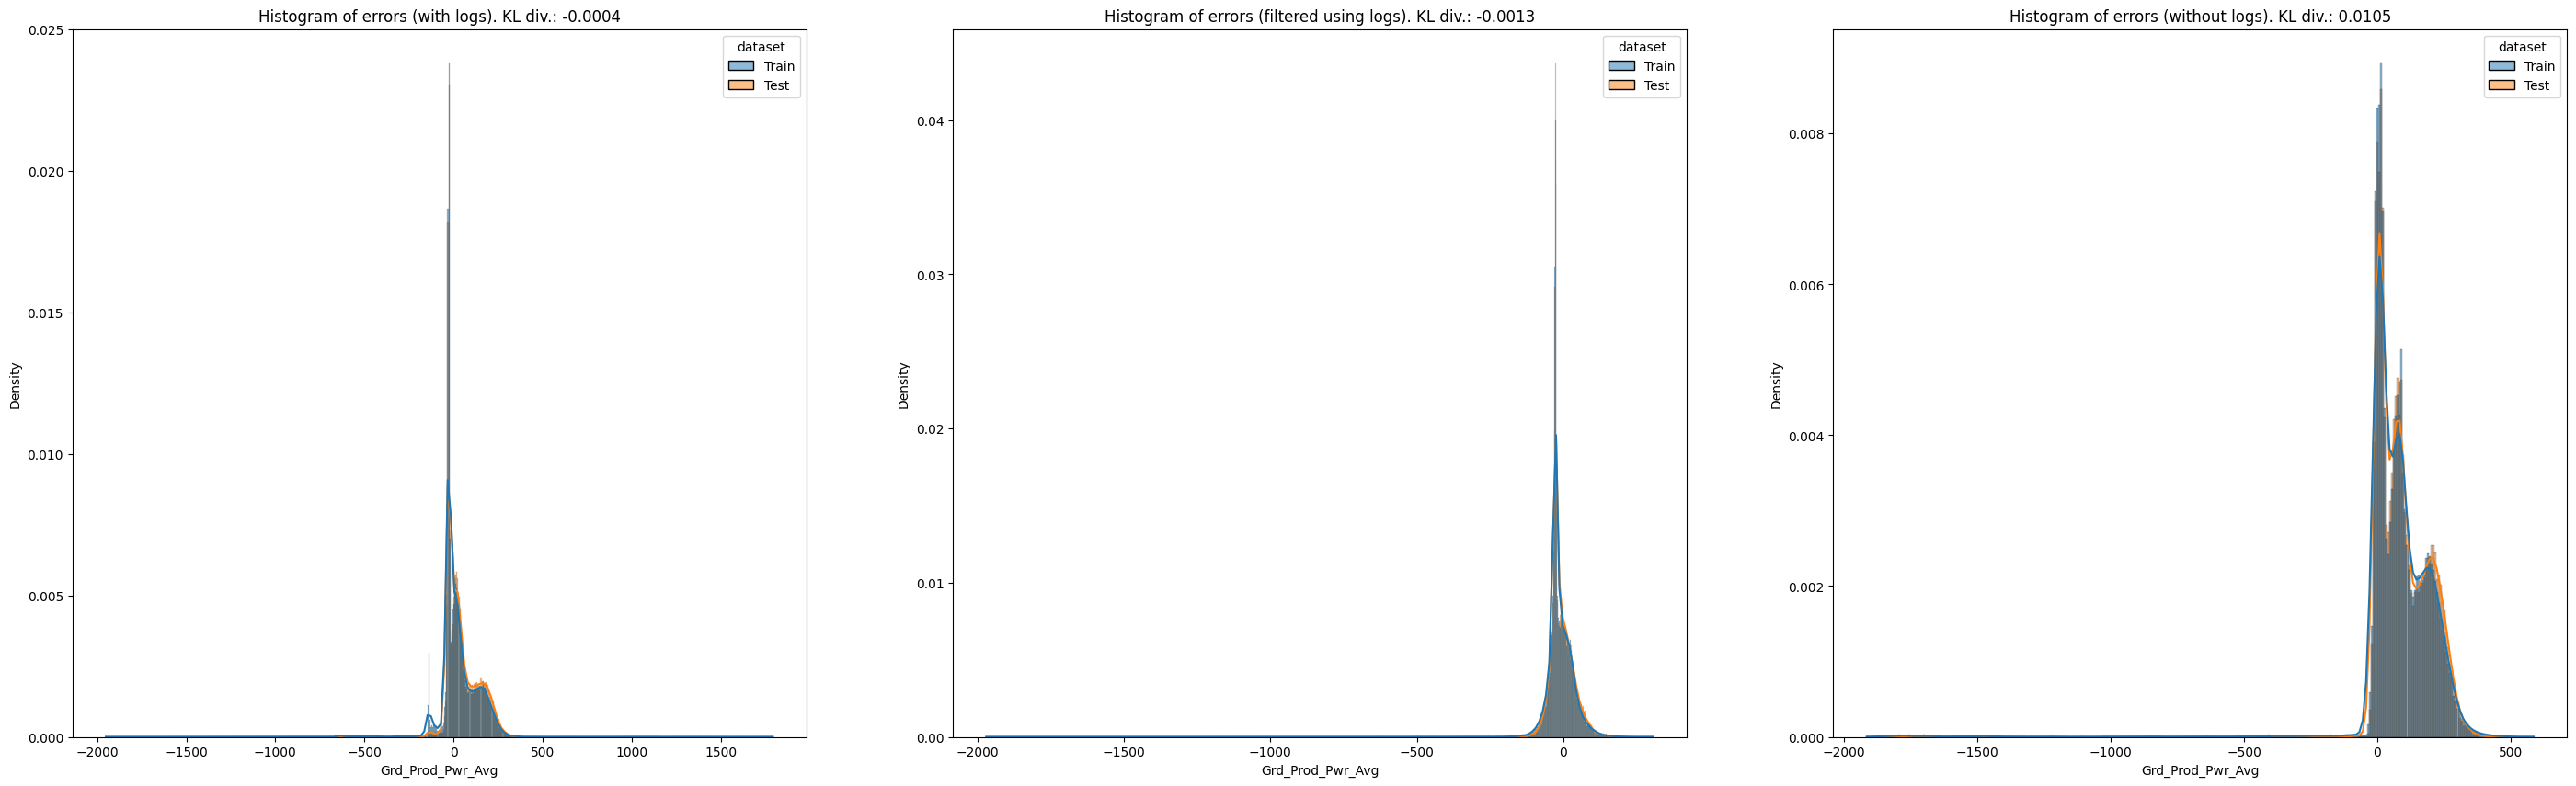

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(35,10))
errors_train_1['dataset'] = 'Train'
errors_test_1['dataset'] = 'Test'

errors_train_1_x['dataset'] = 'Train'
errors_test_1_x['dataset'] = 'Test'

errors_train_1_f['dataset'] = 'Train'
errors_test_1_f['dataset'] = 'Test'

target_feature = target_features[0]

sns.histplot(pd.concat([errors_train_1, errors_test_1], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_1_f, errors_test_1_f], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])
sns.histplot(pd.concat([errors_train_1_x, errors_test_1_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[2])

kl_logs = kl_divergence(np.histogram(errors_train_1[target_feature], density=True)[0], np.histogram(errors_test_1[target_feature], density=True)[0])
kl_filtered = kl_divergence(np.histogram(errors_train_1_f[target_feature], density=True)[0], np.histogram(errors_test_1_f[target_feature], density=True)[0])
kl_no_logs = kl_divergence(np.histogram(errors_train_1_x[target_feature], density=True)[0], np.histogram(errors_test_1_x[target_feature], density=True)[0])

axes[0].set_title('Histogram of errors (with logs). KL div.: {}'.format(round(kl_logs, 4)));
axes[1].set_title('Histogram of errors (filtered using logs). KL div.: {}'.format(round(kl_filtered, 4)));
axes[2].set_title('Histogram of errors (without logs). KL div.: {}'.format(round(kl_no_logs, 4)));

**Train with more features**

In [20]:
features_wout_logs = ['Amb_Temp_Avg', 'Amb_WindSpeed_Avg', 'Rtr_RPM_Avg'] + target_features
features_w_logs = features_wout_logs + ['Remark']

In [21]:
#Train with log features
dataset_2, X_train_2, Y_train_2, predictions_train_2, errors_train_2, X_test_2, Y_test_2, predictions_test_2, errors_test_2, model_2, scaler_input, scaler_target, rmse_train_2, rmse_test_2 = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_w_logs, epochs=100, normalize=True);

Training model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                50        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
521/521 - 3s - loss: 0.0513 - 3s/epoch - 5ms/step
Epoch 2/100
521/521 - 3s - loss: 0.0206 - 3s/epoch - 5ms/step
Epoch 3/100
521/521 - 3s - loss: 0.0099 - 3s/epoch - 5ms/step
Epoch 4/100
521/521 - 3s - loss: 0.0055 - 3s/epoch - 5ms/step
Epoch 5/100
521/521 - 3s - loss: 0.0038 - 3s/epoch - 5

In [22]:
#Train with filtered data based on log features
dataset_2_f, X_train_2_f, Y_train_2_f, predictions_train_2_f, errors_train_2_f, X_test_2_f, Y_test_2_f, predictions_test_2_f, errors_test_2_f, model_2_f, scaler_input, scaler_target, rmse_train_2_f, rmse_test_2_f = \
                        implement_pipeline_mlp(T01_data_logs[T01_data_logs.Remark == 1], train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=100, normalize=True);

Training model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                40        
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
503/503 - 3s - loss: 0.0394 - 3s/epoch - 6ms/step
Epoch 2/100
503/503 - 3s - loss: 0.0098 - 3s/epoch - 5ms/step
Epoch 3/100
503/503 - 3s - loss: 0.0050 - 3s/epoch - 5ms/step
Epoch 4/100
503/503 - 3s - loss: 0.0031 - 3s/epoch - 5ms/step
Epoch 5/100
503/503 - 2s - loss: 0.0023 - 2s/epoch - 5

In [23]:
#Train with filtered data based on rotor speed
dataset_2_fr, X_train_2_fr, Y_train_2_fr, predictions_train_2_fr, errors_train_2_fr, X_test_2_fr, Y_test_2_fr, predictions_test_2_fr, errors_test_2_fr, model_2_fr, scaler_input, scaler_target, rmse_train_2_fr, rmse_test_2_fr = \
                        implement_pipeline_mlp(T01_data_logs[T01_data_logs.Rtr_RPM_Avg > 0], train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=100, normalize=True);

Training model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                40        
                                                                 
 dense_19 (Dense)            (None, 10)                110       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
449/449 - 2s - loss: 0.0433 - 2s/epoch - 6ms/step
Epoch 2/100
449/449 - 2s - loss: 0.0105 - 2s/epoch - 5ms/step
Epoch 3/100
449/449 - 2s - loss: 0.0055 - 2s/epoch - 5ms/step
Epoch 4/100
449/449 - 2s - loss: 0.0035 - 2s/epoch - 5ms/step
Epoch 5/100
449/449 - 2s - loss: 0.0026 - 2s/epoch - 5

In [24]:
#Train without log features
dataset_2_x, X_train_2_x, Y_train_2_x, predictions_train_2_x, errors_train_2_x, X_test_2_x, Y_test_2_x, predictions_test_2_x, errors_test_2_x, model_2_x, scaler_input, scaler_target, rmse_train_2_x, rmse_test_2_x = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=100, normalize=True);

Training model...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 10)                40        
                                                                 
 dense_22 (Dense)            (None, 10)                110       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
521/521 - 3s - loss: 0.0385 - 3s/epoch - 5ms/step
Epoch 2/100
521/521 - 2s - loss: 0.0102 - 2s/epoch - 5ms/step
Epoch 3/100
521/521 - 2s - loss: 0.0053 - 2s/epoch - 5ms/step
Epoch 4/100
521/521 - 2s - loss: 0.0033 - 2s/epoch - 5ms/step
Epoch 5/100
521/521 - 2s - loss: 0.0024 - 2s/epoch - 5

Distribution of errors

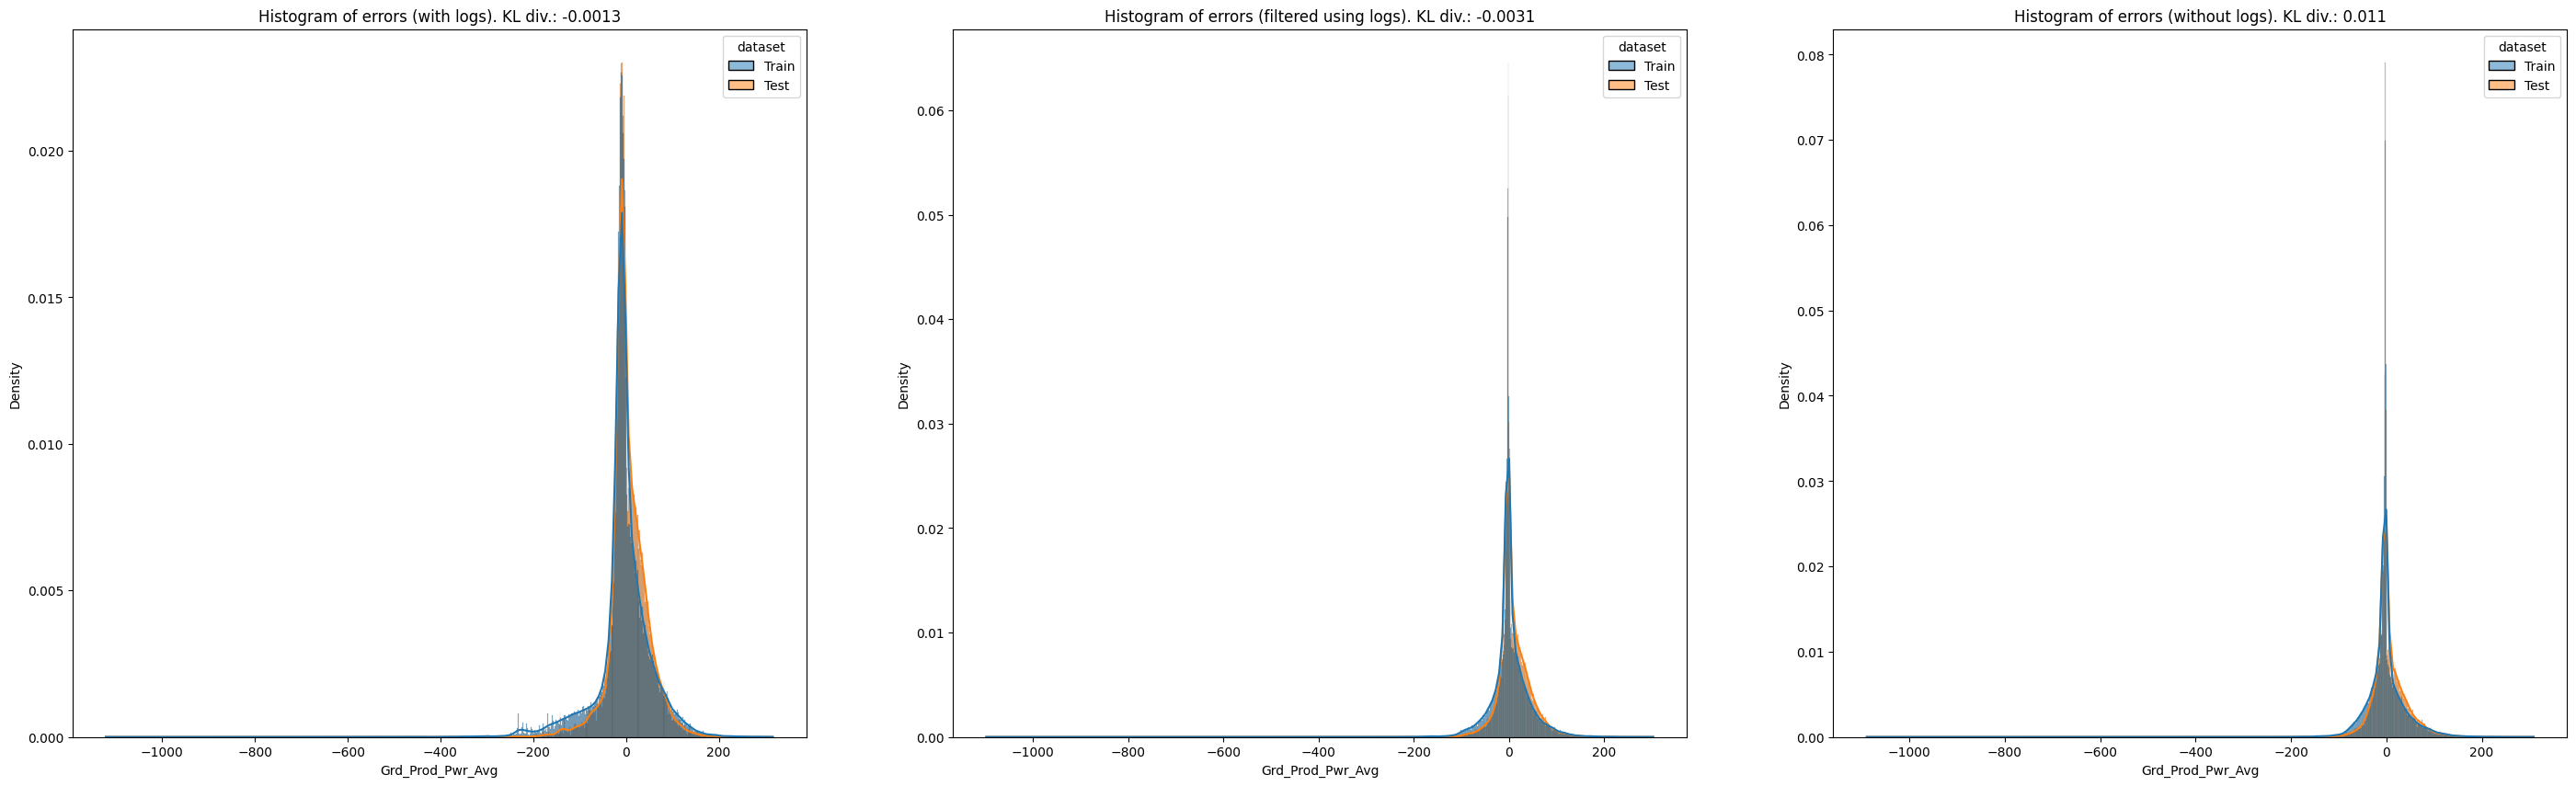

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(35,10))
errors_train_2['dataset'] = 'Train'
errors_test_2['dataset'] = 'Test'

errors_train_2_x['dataset'] = 'Train'
errors_test_2_x['dataset'] = 'Test'

errors_train_2_f['dataset'] = 'Train'
errors_test_2_f['dataset'] = 'Test'

target_feature = target_features[0]

sns.histplot(pd.concat([errors_train_2, errors_test_2], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_2_f, errors_test_2_f], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])
sns.histplot(pd.concat([errors_train_2_x, errors_test_2_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[2])

kl_logs = kl_divergence(np.histogram(errors_train_2[target_feature], density=True)[0], np.histogram(errors_test_2[target_feature], density=True)[0])
kl_filtered = kl_divergence(np.histogram(errors_train_2_f[target_feature], density=True)[0], np.histogram(errors_test_2_f[target_feature], density=True)[0])
kl_no_logs = kl_divergence(np.histogram(errors_train_2_x[target_feature], density=True)[0], np.histogram(errors_test_2_x[target_feature], density=True)[0])

axes[0].set_title('Histogram of errors (with logs). KL div.: {}'.format(round(kl_logs, 4)));
axes[1].set_title('Histogram of errors (filtered using logs). KL div.: {}'.format(round(kl_filtered, 4)));
axes[2].set_title('Histogram of errors (without logs). KL div.: {}'.format(round(kl_no_logs, 4)));

Anomaly detection (assuming the error distribution is Gaussian for simplification)

In [26]:
anomaly_threshold_1 = errors_train_1[target_feature].mean() + 3 * errors_train_1[target_feature].std()

Y_test_1['Anomaly'] = errors_test_1[target_feature] > anomaly_threshold_1
Y_train_1['Anomaly'] = errors_train_1[target_feature] > anomaly_threshold_1

anomaly_threshold_1_x = errors_train_1_x[target_feature].mean() + 3 * errors_train_1_x[target_feature].std()

Y_test_1_x['Anomaly'] = errors_test_1_x[target_feature] > anomaly_threshold_1_x
Y_train_1_x['Anomaly'] = errors_train_1_x[target_feature] > anomaly_threshold_1_x

print('Anomaly threshold (using log feature): ', anomaly_threshold_1)
print('Anomaly threshold (not using log feature): ', anomaly_threshold_1_x)

Anomaly threshold (using log feature):  382.88041060860684
Anomaly threshold (not using log feature):  561.1815063314955


Append relevant log warning message(s) from the previous 24 hours, if found, to data points labeled as anomaly

In [27]:
Y_test_1 = append_relevant_log_warnings(Y_test_1, log_data_T09, 'Remark', target_feature, filter_by='Anomaly', max_distance='24H')
Y_test_1_x = append_relevant_log_warnings(Y_test_1_x, log_data_T09, 'Remark', target_feature, filter_by='Anomaly', max_distance='24H')

NameError: name 'log_data_T09' is not defined

Label data points at time of gen bearing replacement

In [ ]:
Y_test_1.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
Y_test_1.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

Y_test_1_x.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
Y_test_1_x.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

#Add date column
Y_test_1['date'] = pd.to_datetime(Y_test_1.index.date)
Y_test_1_x['date'] = pd.to_datetime(Y_test_1_x.index.date)

Extract days where at least one anomaly was detected to visualize data

In [ ]:
#gt -> ground truth, pr -> predictions, x -> input features
gt_1 = Y_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))].reset_index()
pr_1 = predictions_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))].reset_index()
x_1 = X_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


All anomalies detected by model_1 (NBM with log features) (click on img to zoom)

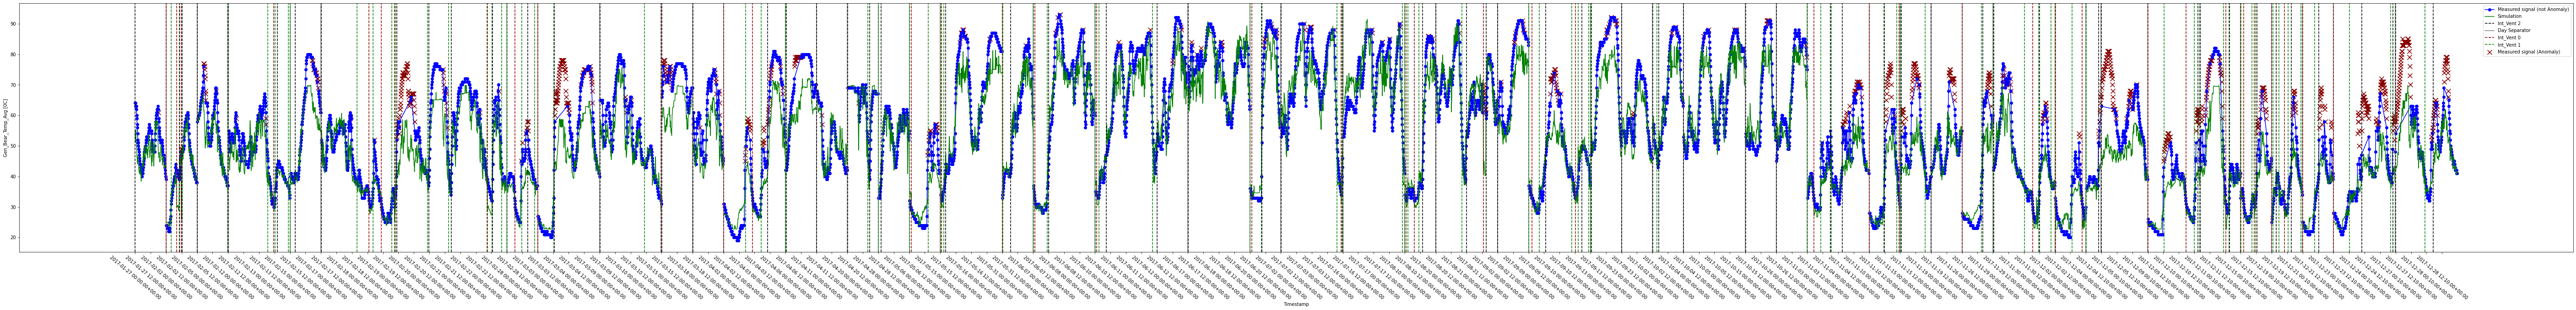

In [ ]:
plot_predicted_vs_true(pr_1, gt_1, target_feature, hue='Anomaly', figsize=(100,10))
plot_control_signals(x_1, 'Int_Vent')

plt.xticks(range(0, gt_1.shape[0], 72), labels = gt_1['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1 (NBM with log features) and not by model_1_x (NBM without log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


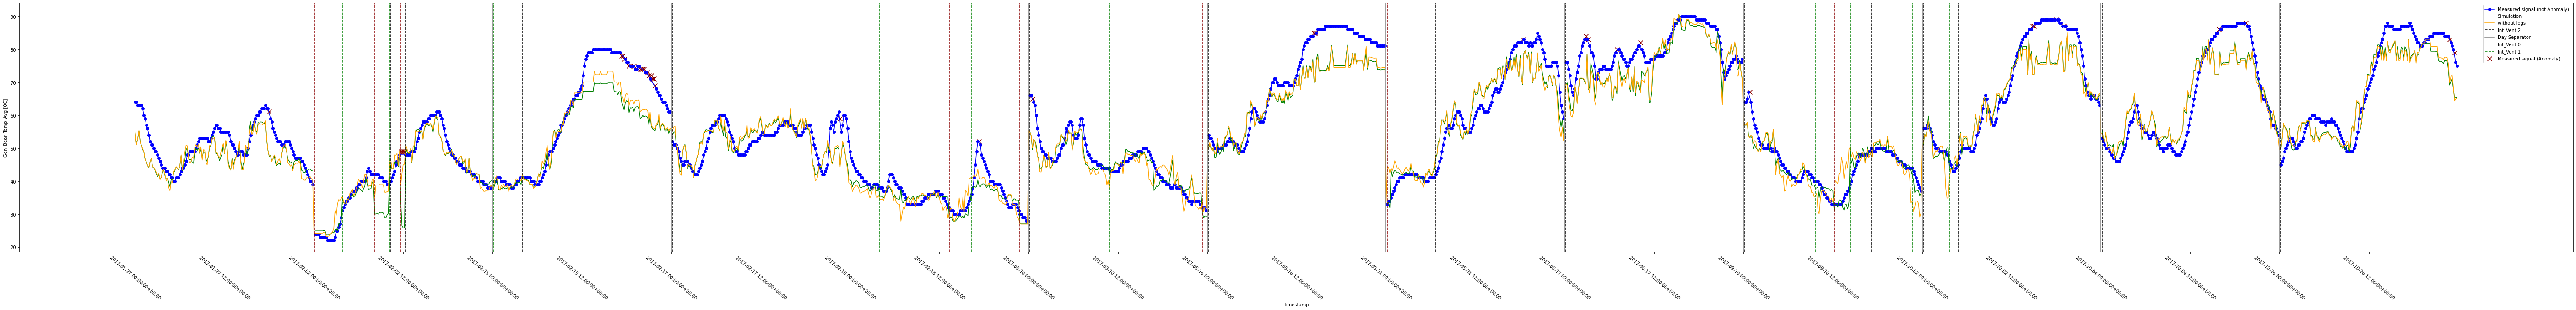

In [ ]:
ixes = (Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))) & ~(Y_test_1.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date)))

gt_1 = Y_test_1[ixes].reset_index()
pr_1 = predictions_test_1[ixes].reset_index()
x_1 = X_test_1[ixes].reset_index()

pr_1_x = predictions_test_1_x[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1, gt_1, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1_x.index, pr_1_x[target_feature], color='orange', label='without logs')
plot_control_signals(x_1, 'Int_Vent')

plt.xticks(range(0, gt_1.shape[0], 72), labels = gt_1['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1_x (NBM without log features) and not by model_1 (NBM with log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


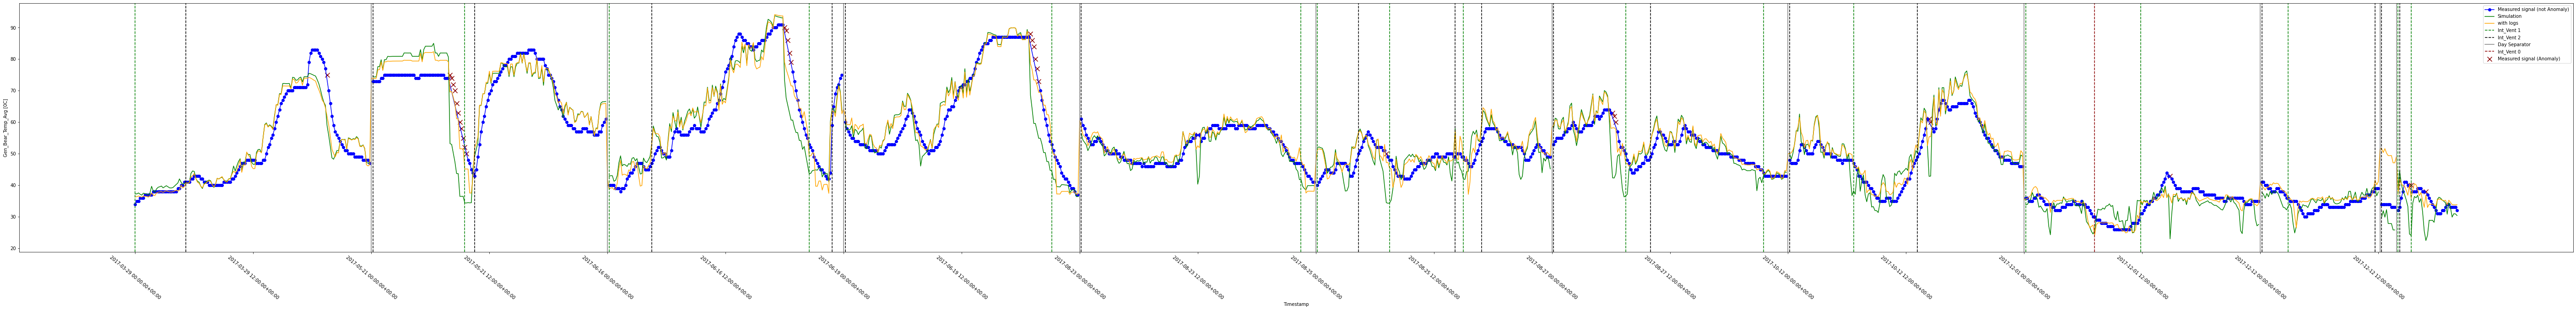

In [ ]:
ixes = (Y_test_1_x.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date))) & ~(Y_test_1_x.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date)))

gt_1_x = Y_test_1_x[ixes].reset_index()
pr_1_x = predictions_test_1_x[ixes].reset_index()
x_1_x = X_test_1[ixes].reset_index()

pr_1 = predictions_test_1[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1_x.loc[x_1_x['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1_x, gt_1_x, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1.index, pr_1[target_feature], color='orange', label='with logs')
plot_control_signals(x_1_x, 'Int_Vent')

plt.xticks(range(0, gt_1_x.shape[0], 72), labels = gt_1_x['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());